# EAN13

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
% cd /content/drive/MyDrive/MIPT/ocr

In [ ]:
! pip install opencv-contrib-python==4.5.4.60
! pip install pytorch-lightning
! pip install wandb

In [185]:
import os
import cv2
import csv
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
from collections import OrderedDict
from shapely.geometry import Polygon
from pyzbar.pyzbar import decode, ZBarSymbol

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.utils as vutils
from torchvision import models
from torchvision import transforms as VT

import pytorch_lightning as pl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import wandb
wandb.login()

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

## Data preparation

In [ ]:
def read_file(path):
	markup = {}
	with open(path, 'r', encoding='utf-16') as fd:
		rd = csv.reader(fd)
		next(rd)
		for row in rd:
			id = row[0]
			value = row[1]
			points = [(int(row[i]), int(row[i + 1])) for i in range(2, 10, 2)]
			markup[id] = [value, points]
	return markup

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/MIPT/ocr/task3/Train'
TEST_PATH = '/content/drive/MyDrive/MIPT/ocr/task3/Test'
train_filenames = os.listdir(os.path.join(TRAIN_PATH, 'Images'))
test_filenames = os.listdir(os.path.join(TEST_PATH, 'Images'))

In [ ]:
markup_train = read_file(os.path.join(TRAIN_PATH, 'markup.csv'))
markup_wo_inv = read_file(os.path.join(TRAIN_PATH, 'markup_wo_inverted.csv'))
markup_test = read_file('/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/markup.csv')

### Bounding box dataset

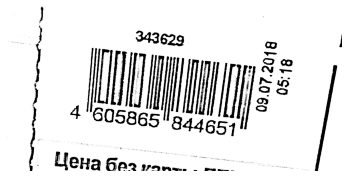

In [194]:
img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN_PATH, 'Images/' + train_filenames[8])), cv2.COLOR_BGR2GRAY)
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, 11)

plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.show()

In [ ]:
class BBDataset(Dataset):
    def __init__(self, filenames, root, markup):
        self.data = []
        transform = VT.Compose([
            VT.Resize((224, 224), VT.InterpolationMode.BICUBIC),
            VT.ToTensor(),
            VT.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        for i in tqdm(range(len(filenames))):
            f = os.path.join(root, filenames[i])
            img = cv2.imread(f)
            h, w, c = img.shape
            img = cv2.adaptiveThreshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, 11)
            img = np.repeat(img[..., np.newaxis], 3, -1)
            img = Image.fromarray(img)
            resized_img = transform(img)
            points = markup[filenames[i]][1]
            resized_points = np.array(list(map(lambda x: ((x[0] / w), (x[1] / h)), points)))
            self.data.append((resized_img.float(), torch.from_numpy(resized_points).float()))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [ ]:
# gray_train_dataset = BBDataset(train_filenames, os.path.join(TRAIN_PATH, 'Images'), markup_train)
# torch.save(gray_train_dataset, '/content/drive/MyDrive/MIPT/ocr/task3/gray_train_dataset.pt')
# gray_test_dataset = BBDataset(test_filenames, os.path.join(TEST_PATH, 'Images'), markup_test)
# torch.save(gray_test_dataset, '/content/drive/MyDrive/MIPT/ocr/task3/gray_test_dataset.pt')
gray_train_dataset = torch.load('/content/drive/MyDrive/MIPT/ocr/task3/gray_train_dataset.pt')
gray_test_dataset = torch.load('/content/drive/MyDrive/MIPT/ocr/task3/gray_test_dataset.pt')

# color dataset
# train_dataset = torch.load('/content/drive/MyDrive/MIPT/ocr/task3/train_dataset.pt')
# test_dataset = torch.load('/content/drive/MyDrive/MIPT/ocr/task3/test_dataset.pt')

In [ ]:
n = len(gray_train_dataset)
train_data, val_data = random_split(gray_train_dataset, [int(0.9 * n), n - int(0.9 * n)])

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=128, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


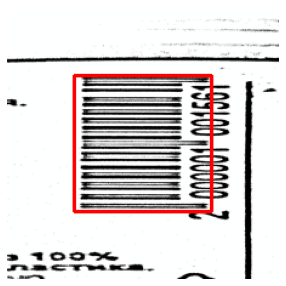

In [ ]:
img, points = gray_train_dataset[0]
img = img.permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
points = points.detach().cpu().numpy()

draw_img = img.copy()
for i in range(len(points)):
    j = (i + 1) % len(points)
    cv2.line(draw_img, tuple(list(map(int, points[i] * 224))), tuple(list(map(int, points[j] * 224))), (255, 0, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(draw_img)
plt.axis('off')
plt.show()

## Model

### Bounding box model

In [ ]:
class Detector(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.metric = nn.MSELoss(reduction='mean')
        self.save_hyperparameters()
        self.model = models.resnet34(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 8),
            nn.Sigmoid()
        )

    def forward(self, imgs):
        points = self.model(imgs)
        return points.view(-1, 4, 2)

    def training_step(self, batch, batch_idx):
        imgs, points = batch
        out_points = self(imgs)
        loss = self.metric(out_points, points)
        self.log("train/loss", loss, on_step=False, on_epoch=True)
        self.log("lr", self.optimizer.param_groups[0]['lr'])
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, points = batch
        out_points = self(imgs)
        loss = self.metric(out_points, points)
        self.log("val/loss", loss, on_step=False, on_epoch=True)
        self.log("lr", self.optimizer.param_groups[0]['lr'])
        return loss

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', factor=0.5, threshold=1e-8)
        lr_scheduler = {"scheduler": self.scheduler, "interval": "epoch", "monitor": "val/loss"}
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": lr_scheduler
        }

In [ ]:
detector = Detector()

wandb.finish()
wandb_logger = WandbLogger(project="OCR")
trainer = Trainer(max_time="00:00:20:00", max_epochs=80, accelerator="gpu", logger=wandb_logger)
trainer.fit(model=detector, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
trainer.save_checkpoint("/content/drive/MyDrive/MIPT/ocr/task3/%s.ckpt" % wandb.run.name)

In [ ]:
detector = Detector.load_from_checkpoint("/content/drive/MyDrive/MIPT/ocr/task3/%s.ckpt" % 'happy-dawn-39').to(device)
detector.eval()

На каких-то примерах получилась неплохая детекция:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


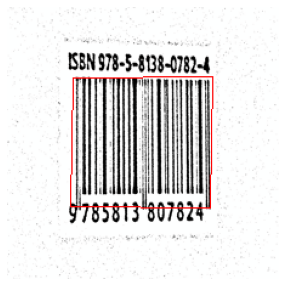

In [ ]:
with torch.no_grad():
    img, points = gray_test_dataset[1]
    generated_points = detector(img.unsqueeze(0).to(device))

img = img.permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
points = generated_points.squeeze(0).detach().cpu().numpy()

draw_img = img.copy()
for i in range(len(points)):
    j = (i + 1) % len(points)
    cv2.line(draw_img, tuple(list(map(int, points[i] * 224))), tuple(list(map(int, points[j] * 224))), (255, 0, 0), 1)

plt.figure(figsize=(5, 5))
plt.imshow(draw_img)
plt.axis('off')
plt.show()

На каких-то плохая:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


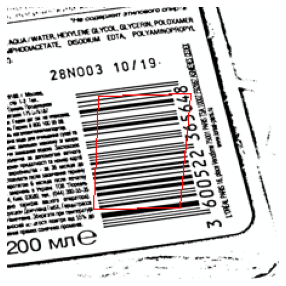

In [ ]:
with torch.no_grad():
    img, points = gray_test_dataset[17]
    generated_points = detector(img.unsqueeze(0).to(device))

img = img.permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
points = generated_points.squeeze(0).detach().cpu().numpy()

draw_img = img.copy()
for i in range(len(points)):
    j = (i + 1) % len(points)
    cv2.line(draw_img, tuple(list(map(int, points[i] * 224))), tuple(list(map(int, points[j] * 224))), (255, 0, 0), 1)

plt.figure(figsize=(5, 5))
plt.imshow(draw_img)
plt.axis('off')
plt.show()

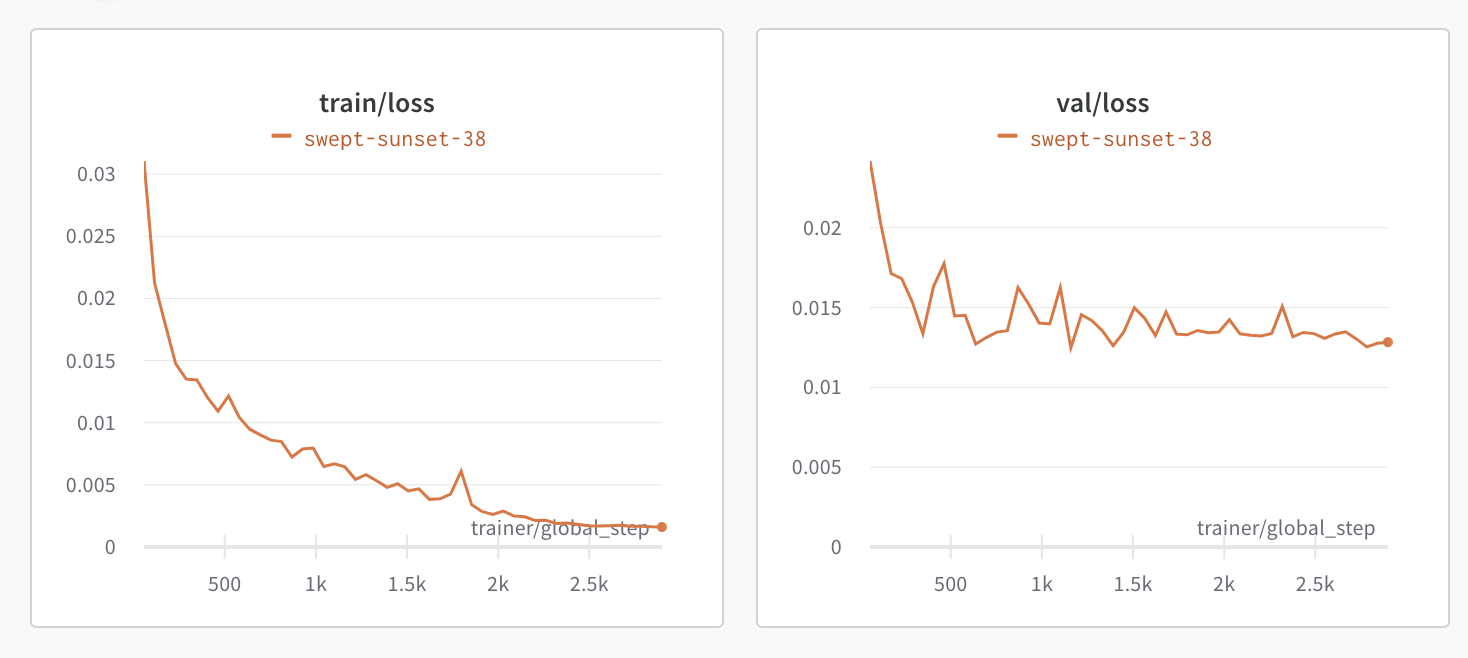

### OpenCV

Учитывая то, что на каких-то изображениях обрезается полностью баркод, то я решила добавить методы классического компьютерного зрения, реализованные с помощью OpenCV.

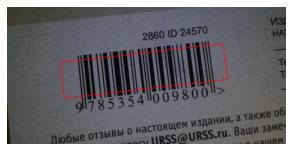

In [ ]:
bardet = cv2.barcode_BarcodeDetector()
img = cv2.imread(os.path.join(TEST_PATH, 'Images/' + test_filenames[0]))
ok, decoded_info, decoded_type, corners = bardet.detectAndDecode(img)

draw_img = img.copy()
for i in range(len(corners[0])):
    j = (i + 1) % len(corners[0])
    cv2.line(draw_img, tuple(list(map(int, corners[0][i]))), tuple(list(map(int, corners[0][j]))), (255, 0, 0), 4)

plt.figure(figsize=(5, 5))
plt.imshow(draw_img)
plt.axis('off')
plt.show()

## Results

In [256]:
bardet = cv2.barcode_BarcodeDetector()
transform = VT.Compose([
            VT.Resize((224, 224), VT.InterpolationMode.BICUBIC),
            VT.ToTensor(),
            VT.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
detector = Detector.load_from_checkpoint("/content/drive/MyDrive/MIPT/ocr/task3/%s.ckpt" % 'happy-dawn-39').to(device)
detector.eval()

ans = pd.DataFrame(columns=['name', 'code', 'x_0', 'y_0', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3'])
sorted_filenames = sorted(test_filenames)
for i in range(len(test_filenames)):
    f = os.path.join(TEST_PATH, 'Images/' + sorted_filenames[i])
    img = cv2.imread(f)
    cur_row = {}
    cur_row['name'] = sorted_filenames[i]
    ok, decoded_info, decoded_type, corners = bardet.detectAndDecode(img)
    if ok:
        cur_row['code'] = decoded_info[0]
        corners = list(map(lambda x: [int(x[0]), int(x[1])], corners[0]))
    else:
        gray = cv2.adaptiveThreshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, 11)
        pyzbar_decode = decode(img, symbols=[ZBarSymbol.EAN13])
        if len(pyzbar_decode) > 0:
            cur_row['code'] = np.array(pyzbar_decode)[0][0].decode('UTF-8')
            borders = np.array(np.array(pyzbar_decode)[0][2])
            corners = np.array([
                [borders[0], borders[1]], 
                [borders[0], borders[1] + borders[3]], 
                [borders[0] + borders[2], borders[1] + borders[3]],
                [borders[0] + borders[2], borders[1]]
            ])
        else:
            h, w, c = img.shape
            gray = np.repeat(gray[..., np.newaxis], 3, -1)
            gray = Image.fromarray(gray)
            resized_gray = transform(gray)
            points = detector(resized_gray.unsqueeze(0).to(device)).squeeze(0).detach().cpu().numpy()
            corners = list(map(lambda x: [int(x[0] * w), int(x[1] * h)], points))

    cur_row['x_0'] = corners[0][0]
    cur_row['y_0'] = corners[0][1]
    cur_row['x_1'] = corners[1][0]
    cur_row['y_1'] = corners[1][1]
    cur_row['x_2'] = corners[2][0]
    cur_row['y_2'] = corners[2][1]
    cur_row['x_3'] = corners[3][0]
    cur_row['y_3'] = corners[3][1]
        
    ans = ans.append(cur_row, ignore_index=True)

In [257]:
ans.to_csv('answer.csv', sep=',', header=False, index=False, encoding='utf-16')

### Testing

In [258]:
def calculate_iou(markup, answer):
	sum_iou = 0.0
	for (k, v) in answer.items():
		a = Polygon(v[1])
		b = Polygon(markup[k][1])
		iou = a.intersection(b).area / a.union(b).area
		sum_iou += iou
	return sum_iou / len(markup)

def calculate_accuracy(markup, answer):
	counter = 0
	for (k, v) in answer.items():
		markup_value = markup[k][0]
		if markup_value == v[0]:
			counter += 1
	return counter / len(markup)

In [259]:
markup_ans = read_file('answer.csv')

In [260]:
recognition_accuracy = calculate_accuracy(markup_test, markup_ans)
print("recognition_accuracy=", recognition_accuracy)
detection_iou = calculate_iou(markup_test, markup_ans)
print("detection_iou=", detection_iou)
score = 0.65 * recognition_accuracy + 0.35 * detection_iou
print("score=", score)

recognition_accuracy= 0.7171717171717171
detection_iou= 0.6460203201299126
score= 0.6922687282070856
